In [35]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np


import wrangle as w
import explore as ex
import model as m


import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

from sklearn.feature_selection import f_regression 
from math import sqrt

#sklearn imports
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.feature_selection import RFE, SelectKBest, f_regression
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
from sklearn.metrics import r2_score

# Project Description
Zillow is a real estate marketplace company. The Zillow dataset is utilized in this project to find drivers for property value for single family properties. 

# Project Goal

* Discover drivers of property value in the Zillow dataset. 
* Use drivers to develop a machine learning model to predict the property value for a single family property.
* Property value is defined as an estimated value for a property.
* This information could be used to further our understanding of which elements contribute to the value of a property.

# Initial Thoughts

The initial hypothesis for this project is that certain factors such as 'area', 'bathrooms', 'year', 'pool', 'bedroom', 'two_bed', 'one_bath','fips', and 'year' may be significant drivers of property value.


# Acquire
* Aquire dataset from Codeup database
* It contained 52,442 rows and 7 columns before cleaning
* Each row represents a property at Zillow
* Each column represents a feature of those properties

# Prepare
- Prepare Actions:
    * Filtered columns that did not contain useful information
    * Renamed columns to promote readability
    * Checked for nulls in the data. The following columns contained nulls:
        - 'pool' (41,346 nulls), nulls changed to 0, these homes were estimated to not have pools
        - 'year' (116 nulls), these rows were dropped  
        - 'area' (82 nulls), these rows were dropped  
        - 'property_value' (1 null), these rows were dropped  
    * Checked that column data types were appropriate
    * Added full_bath column, which divides the type of bathrooms into homes with only full bathrooms and half bathrooms and including one home that has a three-quarters bath.
    * Encoded categorical variables
    * Split data into train, validate and test (approx. 60/20/20)
    * 2,641 outliers have been removed for the iteration of the project, based on if they fell outside the 3 standard deviation
    
# Data Dictionary 
| Feature | Definition |
|:--------|:-----------|
|Property Value (Target)| Value of a single family property|
|Area| The calculated finished square footage|
|Bathrooms| The number of bathrooms, (half baths: .5 & three-quarters bath: .75|
|Bedroom| 0 (No) or 1 (Yes), The number of bedrooms|
|Pool| 0 (No) or 1 (Yes), The home has a pool|
|Year| The year the home was built|
|Full Bath| 0 (No) or 1 (Yes), The home has only full bathrooms|
|Fips| 6037: "LA", 6059: "Orange", 6111: "Ventura"|
|Orange| 0 (No) or 1 (Yes), The home has is located in Orange county|
|Ventura| 0 (No) or 1 (Yes), The home has is located in Ventura county|

In [36]:
# retrieve the data from database or directory 
df = w.get_data()

In [37]:
# clean data, remove nulls, outliers and rename columns
df = w.clean_zillow()

697 outliers removed from property_value.
792 outliers removed from area.
658 outliers removed from bathrooms.
469 outliers removed from bedroom.
0 outliers removed from pool.
25 outliers removed from year.
0 outliers removed from full_bath.

Total of 2641 outliers removed.


In [38]:
# split the data into train, validate, test
train, validate, test = w.split_data(df)

# Summarize df 

In [39]:
# overview of data
train.head()

,property_value,area,bathrooms,bedroom,pool,fips,year,full_bath,orange,ventura
32810,143239.0,1338.0,1.0,2.0,0.0,LA,1953.0,1,0,0
26217,353024.0,1110.0,2.0,3.0,0.0,Ventura,1962.0,1,0,1
13781,709340.0,1560.0,2.0,3.0,0.0,Orange,1965.0,1,1,0
25812,303031.0,1168.0,2.5,2.0,0.0,Orange,1977.0,0,1,0
12771,275213.0,1356.0,2.0,2.0,1.0,LA,1959.0,1,0,0


# Explore

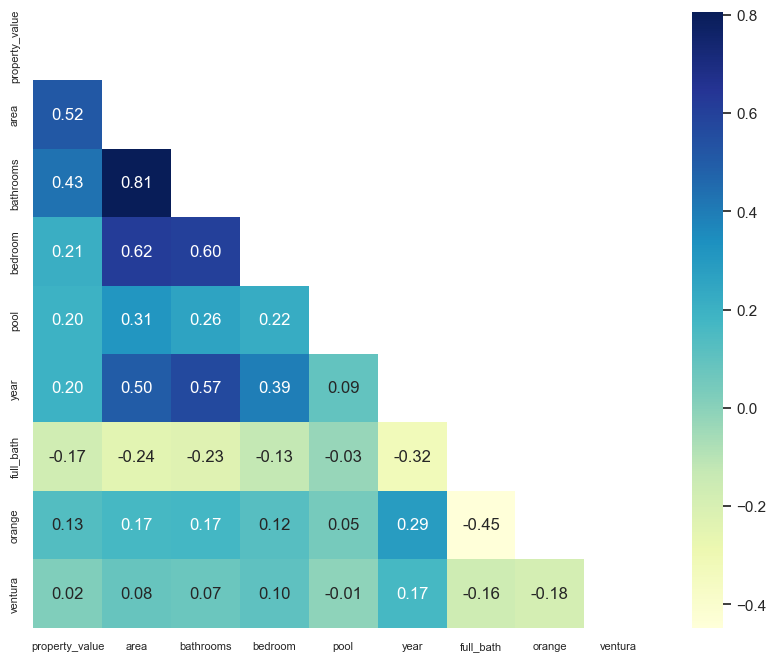

In [40]:
ex.train_heat(train)

## Does Area Affect Property Value?

$H_0$: There is no linear correlation between the area and property value.

$H_a$: There is a linear correlation between the area and property value.

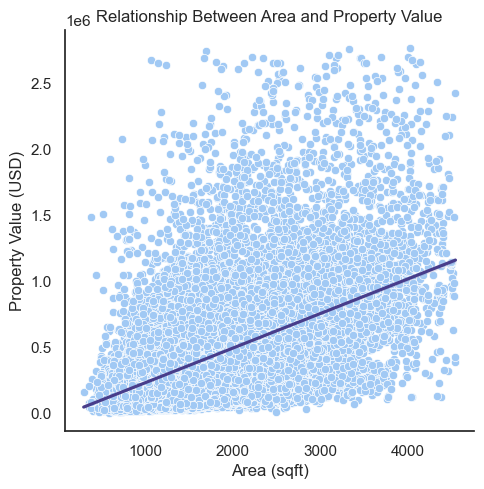

In [41]:
ex.create_relplot(x_var="area", y_var="property_value", df=train)

**There is a positive correlation that area sqft does affect property value. Based on this, I believe that using the area feature in modeling will likely have a small positive impact on the model's accuracy.**

# Is 1 Bathroom Worse for Property Value than 2 Bedrooms?

$H_0$: The average property value for 1 bathroom homes is less than or equal to the average property value for 2 bedroom homes

$H_a$: The average property value for 1 bathroom homes is greater than the average property value for 2 bedroom homes

**I will use an Indenpendent T-Test (1-tailed), to investigate whether having 1 bathroom is worse for property value than having 2 bedrooms**

* I will use a confidence interval of 95%
* The alpha is .05

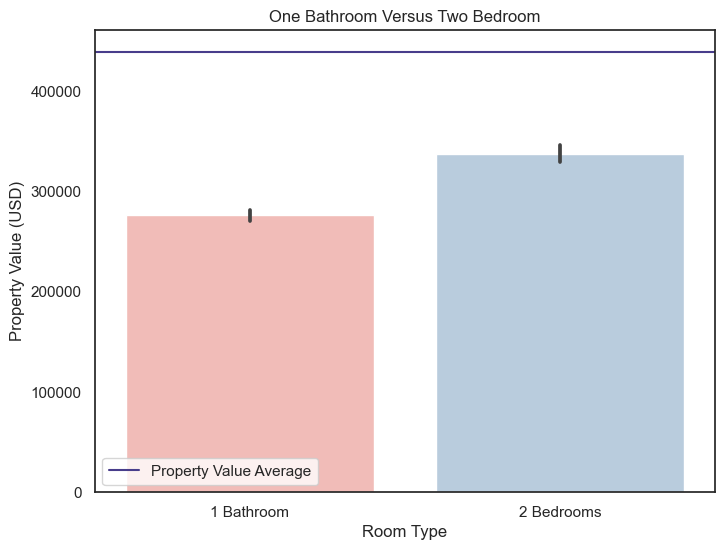

In [42]:
ex.bed_bath_barplot(train)

In [43]:
avg_one_bath = train[train.bathrooms == 1].property_value
avg_two_bed =  train[train.bedroom == 2].property_value

In [44]:
ex.ind_test(avg_one_bath, avg_two_bed)

 Fail to reject the null: Insufficient evidence
 p-value: 8.691807300827496e-31 , t: -11.577209082018319


**We failed the reject the null hypothesis, it is not likely that that the number of bathrooms will be a useful feature to model on.**

## Does Having a Half-Bathroom Better for Property Value than a Full-Bathroom ?

$H_0$: The average property value for homes that have half bathrooms is less than or equal to the average property value for homes with full bathrooms

$H_a$: The average property value for homes that have half bathrooms is greater than the average property value for homes with full bathrooms

**I will use an Independent T-Test (1-tailed), to investigate whether a half bathroom is better for property value than a full bathroom**

* I will use a confidence interval of 95%
* The alpha is .05

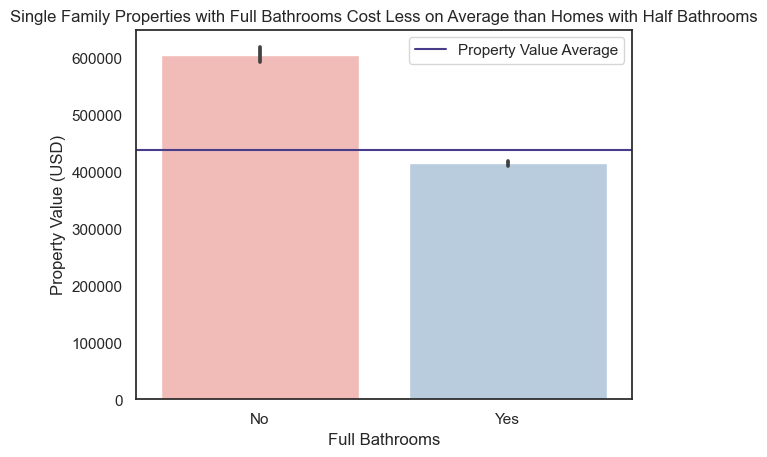

In [45]:
ex.bathroom_barplot(train)

In [46]:
avg_full_bath  = train[train.full_bath == 1].property_value
avg_half_bath = train[train.full_bath == 0].property_value

In [47]:
ex.ind_test(avg_half_bath, avg_full_bath)

Reject the null hypothesis: Sufficient
 p-value: 2.6127059332687752e-154 , t: 27.514713052987528


**We rejected the null hypothesis, therfore, we have evidence to support that homes with half bathrooms are more likely to have a greater property value. Based on this, I believe that using the 'full_bath' feature in modeling will likely have a positive impact on the model's accuracy.**

## Is a pool better for property value?

$H_0$: The average property value for homes with pools is less than or equal to the average property value for homes without pools

$H_a$: The average property value for homes with pools is greater than the average property value for homes without pools

**I will use an Independent T-Test (1-tailed), to investigate whether a property with a pool is better for property value than without a pool**

* I will use a confidence interval of 95%
* The alpha is .05

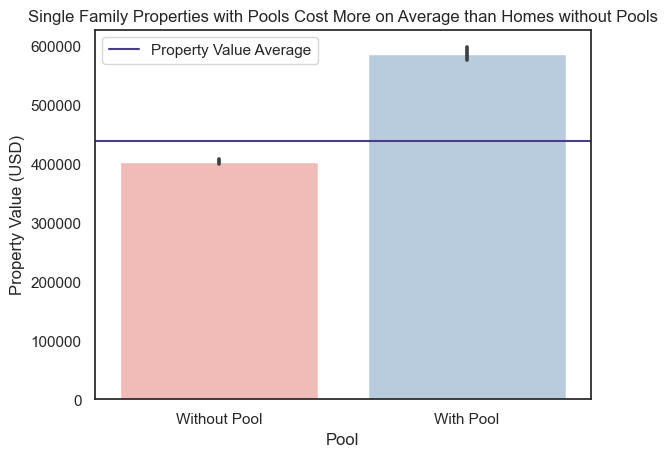

In [48]:
ex.pool_barplot(train)

In [49]:
yes_pool  = train[train.pool == 1].property_value
no_pool = train[train.pool == 0].property_value

In [50]:
ex.ind_test(yes_pool, no_pool)

Reject the null hypothesis: Sufficient
 p-value: 2.331527328632965e-186 , t: 29.955838505425064


**We rejected the null hypothesis, therfore, we have evidence to support that homes with pools have a greater property value, than homes without a pool. Based on this, I believe that using the 'pool' feature in modeling will likely have a small positive impact on the model's accuracy.**

## Is the Property Value for Properties in Orange County Greater than Other Counties?

$H_0$: The average property value for homes in Orange county is less than or equal to the average property value in other counties

$H_a$: The average property value for homes in Orange county is greater than the average property value in other counties

**I will use an Independent T-Test (1-tailed), to investigate whether a property in Orange county is greater than other counties**

* I will use a confidence interval of 95%
* The alpha is .05

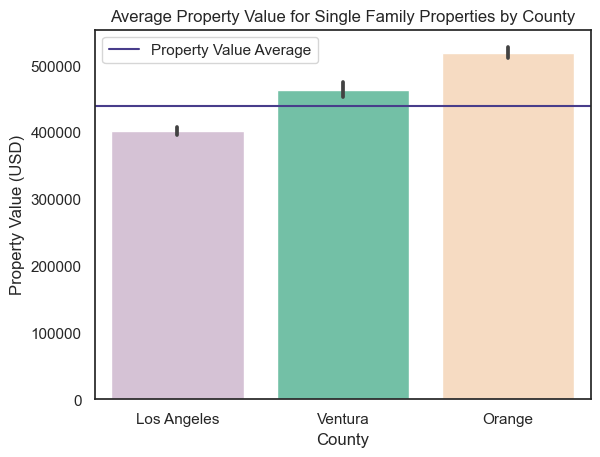

In [51]:
ex.county_barplot(train)

In [52]:
orange_sample = train[train.fips == 'Orange'].property_value
overall_mean = train.property_value.mean()

In [53]:
ex.one_test(orange_sample, overall_mean)

Reject the null hypothesis: Sufficient
 p-value: 3.6036887762007564e-80 , t: 19.174519143295296


**We rejected the null hypothesis, therfore, we have evidence to support that the average property value for homes located in Orange county is greater than the average property value in other counties. Based on this, I believe that using the 'Orange' feature in modeling will likely have a small positive impact on the model's accuracy.**

# Exploration Summary
* 'Area' was found to have a correlation with 'Property Value'
    - A statistically significant correlation (moderate)
* 'Full Bathrooms' was found to be a driver of 'Property Value', properties with more 'Full Bathrooms' tend to have lower property value, than homes with half bathrooms.
    - Observed to have above moderately strong influence
* 'Bedrooms' was found to have a correlation with 'Property Value'
    - A statistically significant correlation (moderate)
* 'Two Bedrooms" and 'One Bathroom' were not found to be drivers of 'Property Value'
    - Statistically insignificant correlation
* 'Pool' was found to be a driver of 'Property Value', properties with more 'Pools' tend to have higher property value, than homes with no 'pools'.
    - Observed to have above moderately strong influence
* 'Year' was found to have a correlation with 'Property Value'
    - Statistically significant correlation (below moderate)
* 'Orange County' and 'Ventura County' were found to be a drivers of 'Property Value'
    - 'Orange County' having a statistically significant correlation (below moderate)
    - 'Ventura County' having a statistically significant correlation (weak)
    
# Features continuing to modeling

* 'Area' (moderate difference in property value is statistically significant)
* 'Full Bathrooms' (large difference observed)
* 'Bedrooms' (moderate difference in property value is statistically significant)
* 'Two Bedrooms" and 'One Bathroom' were not found to be drivers of property value
* 'Pool' (large difference observed)
* 'Year' (below moderate difference in property value is statistically significant)
* 'Orange County'(above small difference in property value is statistically significant)
* 'Ventura County' (small difference in property value is statistically significant)

# Features not continuing to modeling
* 'Two Bedrooms" and 'One Bathroom' was not found to be a driver of property value

# Modeling

* My evaluation metric will use RMSE and R2.
* The average property value is set as the baseline RMSE: 320706.78, R2: 0.00], and will continue to use for this project.
* I will be evaluating models developed using three different model types and various hyperparameter configurations.
* Models will be evaluated on train and validate data.
* The model that performs the best will then be evaluated on test data.

In [54]:
# features and the target variable
features = ['area', 'bathrooms', 'bedroom', 'year', 'pool', 'full_bath','orange', 'ventura']
target = "property_value"

# split the train, validate, test into x and y 
x_train, x_validate, x_test  = train[features], validate[features], test[features]
y_train, y_validate, y_test = train[target], validate[target], test[target]

# scaling the x datasets
x_train_scaled, x_validate_scaled, x_test_scaled = w.mm_scale(x_train, x_validate, x_test)

In [55]:
# creating and adding the baseline
baseline = y_train.mean()
baseline_array = np.repeat(baseline, len(train))
rmse, r2 = m.metrics_reg(y_train, baseline_array)

# metrics dataframe
metrics_df = pd.DataFrame(data=[{'model':'baseline', 'rmse':rmse,'r2':r2}])
metrics_df

,model,rmse,r2
0,baseline,368139.063849,0.0


## LinearRegression (OLS)

In [56]:
x_train_scaled

,area,bathrooms,bedroom,year,pool,full_bath,orange,ventura
0,0.244696,0.222222,0.25,0.479339,0.0,1.0,0.0,0.0
1,0.190948,0.444444,0.50,0.553719,0.0,1.0,0.0,1.0
2,0.297030,0.444444,0.50,0.578512,0.0,1.0,1.0,0.0
3,0.204620,0.555556,0.25,0.677686,0.0,0.0,1.0,0.0
4,0.248939,0.444444,0.25,0.528926,1.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...
29802,0.378359,0.444444,0.50,0.239669,0.0,1.0,0.0,0.0
29803,0.255068,0.444444,0.50,0.628099,0.0,1.0,0.0,1.0
29804,0.341820,0.444444,0.25,0.165289,0.0,1.0,0.0,0.0
29805,0.288307,0.444444,0.25,0.446281,0.0,1.0,0.0,0.0


In [57]:
# make the model, fit and use it on train and validate
ols_rmse, ols_r2 = m.ols_mod(x_train_scaled, x_validate_scaled, y_train, y_validate)
# add to metrics_reg
metrics_df.loc[1] = ['ols', ols_rmse, ols_r2]

##  LassoLars

In [58]:
lars_rmse, lars_r2 = m.lars_mod(x_train_scaled, x_validate_scaled, y_train, y_validate)
metrics_df.loc[2] = ['lars', lars_rmse, lars_r2]

## TweedieRegressor (GLM)

In [59]:
glm_rmse, glm_r2 = m.glm_mod(x_train_scaled, x_validate_scaled, y_train, y_validate)
metrics_df.loc[3] = ['glm', glm_rmse, glm_r2]

## Polynomial Regression

In [60]:
ploy_rmse, ploy_r2 = m.poly_mod(x_train_scaled, x_validate_scaled, x_test_scaled, y_train, y_validate)
metrics_df.loc[4] = ['poly', ploy_rmse, ploy_r2]

# Metrics for Models

In [61]:
metrics_df

,model,rmse,r2
0,baseline,368139.063849,0.000000
1,ols,308070.132048,0.310140
2,lars,308074.574071,0.310120
3,glm,308070.131760,0.310140
4,poly,299234.980767,0.349142


# Comparing Models
* All of the models preformed better than the baseline
* The best model overall was the Polynomial Regression which had the lowest RMSE and R2 
* I have chosen to move forward with the Polynomial Regression model.

# Polynomial Regression on Test

In [62]:
test_rmse, test_r2 = m.best_model(x_train_scaled, x_test_scaled, y_train, y_test)
metrics_df.loc[5] = ['final test', test_rmse, test_r2]

In [63]:
metrics_df.loc[4:]

,model,rmse,r2
4,poly,299234.980767,0.349142
5,final test,304801.650229,0.353654


# Conclusions

### Exploration
* 'Area' and 'Bedrooms' was found to have a moderate signifcant correlation with 'Property Value'
* 'Full Bathrooms' was observed to have a moderately strong influence of 'Property Value'
* 'Two Bedrooms" and 'One Bathroom' were not found to be drivers of 'Property Value'
* 'Pool' was observed to have a moderately strong influence of 'Property Value'
* 'Year' was found to have a below moderate significant correlation with 'Property Value'
* 'Orange County' having below moderate significant correlation with 'Property Value'
* 'Ventura County' is a weak significane with 'Property Value'

### Modeling Takeaways 
The final model significantly outperformed the baseline. Polynomial Regression which had the lowest RMSE and highest R2. The model preformed with a RMSE: 304738.388531	R2:0.351256


### Recommendations
* To increase the model performance an additional feature
    - Properties with or without an HOA
    - Properties with or without a basement 
    - Property exterior features: siding, roof type, and floor type
    - Population density within the area

### Next Steps
* I would like to explore further into geographic locations and how the population density can affect the property value.
* I would like to explore other features, such as stories and central air-conditioning to find other driving factors. 